In [1]:
import irbasis
import numpy as np
from numpy.fft import fftn, ifftn

beta = 1000.0
Lambda = 100000.0
wmax = Lambda/beta
print("wmax", wmax)

b = irbasis.load('F', wmax * beta)
dim = b.dim()
print("dim", dim)

# Sampling points in x
sp_x = b.sampling_points_x(whichl=dim-1)
print(sp_x)

# Sampling frequencies in n
sp_n = b.sampling_points_matsubara(whichl=dim-1)
print(sp_n)

all_ls = np.arange(dim)

# Compute F and pseudo inverse
# for imaginary time
Ftau = np.sqrt(2/beta) * \
    b.ulx(all_ls[:, None], sp_x[None,:]).T
invFtau = np.linalg.pinv(Ftau)

# Compute F and pseudo inverse
# for imaginary frequency
hatF = np.sqrt(beta) * b.compute_unl(sp_n)
invhatF = np.linalg.pinv(hatF)
;

wmax 100.0
dim 137
[-9.99999349e-01 -9.99995910e-01 -9.99988078e-01 -9.99975679e-01
 -9.99958583e-01 -9.99936609e-01 -9.99909515e-01 -9.99876994e-01
 -9.99838661e-01 -9.99794038e-01 -9.99742544e-01 -9.99683469e-01
 -9.99615956e-01 -9.99538971e-01 -9.99451277e-01 -9.99351398e-01
 -9.99237584e-01 -9.99107772e-01 -9.98959539e-01 -9.98790060e-01
 -9.98596051e-01 -9.98373708e-01 -9.98118638e-01 -9.97825772e-01
 -9.97489274e-01 -9.97102421e-01 -9.96657477e-01 -9.96145535e-01
 -9.95556343e-01 -9.94878101e-01 -9.94097223e-01 -9.93198063e-01
 -9.92162610e-01 -9.90970121e-01 -9.89596709e-01 -9.88014866e-01
 -9.86192915e-01 -9.84094377e-01 -9.81677247e-01 -9.78893162e-01
 -9.75686442e-01 -9.71992998e-01 -9.67739074e-01 -9.62839823e-01
 -9.57197668e-01 -9.50700468e-01 -9.43219427e-01 -9.34606774e-01
 -9.24693187e-01 -9.13284987e-01 -9.00161151e-01 -8.85070235e-01
 -8.67727382e-01 -8.47811680e-01 -8.24964336e-01 -7.98788311e-01
 -7.68850425e-01 -7.34687291e-01 -6.95816941e-01 -6.51758408e-01
 -6.02

''

In [2]:
# Parameters
nk_lin = 64
U, kps  = 2.0, np.array([nk_lin, nk_lin])
nw = len(sp_n)
ntau = len(sp_x)

# Generate k mesh and non-interacting band energies
nk = np.prod(kps)
kgrid = [2*np.pi*np.arange(kp)/kp for kp in kps]
k1, k2 = np.meshgrid(*kgrid, indexing='ij')
ek = -2*(np.cos(k1) + np.cos(k2))
iw = 1j*np.pi*(2*sp_n+1)/beta

# G(iw, k): (nw, nk)
gkf = 1.0 / (iw[:,None] - ek.ravel()[None,:])

# G(l, k): (L, nk)
gkl = invhatF @ gkf

# G(tau, k): (ntau, nk)
gkt = Ftau @ gkl

# G(tau, r): (ntau, nk)
grt = np.fft.fftn(gkt.reshape(ntau, *kps), axes=(1,2)).\
    reshape(ntau, nk)

# Sigma(tau, r): (ntau, nk)
srt = U*U*grt*grt*grt[::-1,:]

# Sigma(l, r): (L, nk)
srl = invFtau @ srt

# Sigma(iw, r): (nw, nk)
srf = hatF @ srl

# Sigma(iw, k): (nw, kps[0], kps[1])
srf = srf.reshape(len(sp_n), *kps)
skf = ifftn(srf, axes=(1,2))/nk**2

In [3]:
# Reference calculation with FFT
def use_fft(nf):
    # start calculation #
    mp = np.concatenate([np.arange(1,nf,2), -np.arange(1,nf,2)[::-1]])
    #mp = np.concatenate([-np.arange(1,nf,2)[::-1], np.arange(1,nf,2)])
    iw = 1j*np.pi*mp/beta
    _if = np.outer(iw, np.ones(nk))
    _ek = np.outer(np.ones(nf), ek)
    gkf = 1.0 / (_if - _ek)
    grt = fftn(gkf.reshape(nf, kps[0], kps[1]), axes=(0,1,2)).reshape(nf, nk)
    grt = np.einsum('i,ij->ij', np.exp(-1j*np.pi/nf*np.arange(nf)), grt, optimize="optimal")
    srt = U*U*grt*grt*grt[::-1,:]
    skf = np.einsum('i,ij->ij', np.exp( 1j*np.pi/nf*np.arange(nf)), srt, optimize="optimal")
    skf = ifftn(skf.reshape(nf, kps[0], kps[1]), axes=(0,1,2))/beta/beta/nk/nk
    return iw, skf

iw_fft, skf_fft = use_fft(10000)

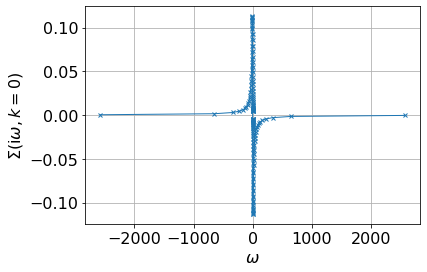

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 16

plt.plot(iw.imag, skf[:,0,0].imag, marker='x', label='Sparse sampling', markersize=4, linewidth=1)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\Sigma(\mathrm{i}\omega, k=0)$")
#plt.legend(loc='best', frameon=False)
#plt.xlim([-500,500])
plt.grid()
#plt.tight_layout()
plt.savefig("sigma_2nd_perb.pdf", bbox_inches="tight")

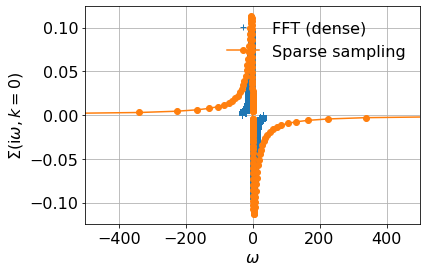

In [8]:
import matplotlib.pyplot as plt

plt.plot(iw_fft.imag, skf_fft[:,0,0].imag, marker='+', ls='', label='FFT (dense)')
plt.plot(iw.imag, skf[:,0,0].imag, marker='o', label='Sparse sampling')
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\Sigma(\mathrm{i}\omega, k=0)$")
plt.legend(loc='best', frameon=False)
plt.xlim([-500,500])
plt.grid()
#plt.savefig("sigma_2nd_perb.pdf")

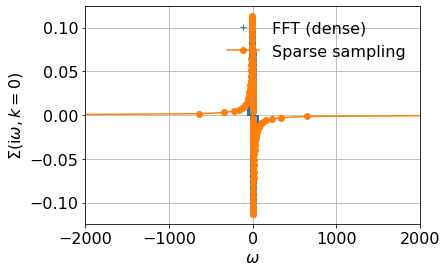

In [6]:
plt.plot(iw_fft.imag, skf_fft[:,0,0].imag,  ls='', marker='+', label='FFT (dense)')
plt.plot(iw.imag, skf[:,0,0].imag, marker='o', label='Sparse sampling')
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\Sigma(\mathrm{i}\omega, k=0)$")
plt.legend(loc='best', frameon=False)
plt.xlim([-2000,2000])
plt.grid()